### "Call a daggum timeout!"

-Roy Williams, probably never

## Introduction

Basketball fans generally believe that calling timeouts can slow or stop scoring runs. Certain coaches (famously, Roy Williams) are often criticized for not calling timeouts when their teams are on the wrong side of a run (referred to as the "slipping" team in this work). Fans can be insistent that timeouts <i>must</i> be called in these situtions. However, to the best of my knowledge, this general wisdom has never been tested nor supported by any actual analysis. Previously, I explored this relationship using Bayesian statistics to suggest that calling a timeout either has no effect or even decreases the probability of runs ending. This analysis had some flaws, largely because 1. the criteria for "ending" a run are unclear, and 2. there are so many timeouts in college basketball that the prior probability of a run ending (i.e., no timeout called) was perhaps inaccurate. 

To address these issues, we looked to a method that requires no parameterization to determine when a run is considered over. We look at the expected value of a timeout by categorizing scoring runs based on their point values and comparing the sequences of events that occur after that timeout. The high frequency of timeouts once again complicates the analysis as it seems questionable to consider a timeout effective if multiple are called, but in this work, we ignore this complication and look strictly at the expected point gain/loss. 

In this work, we will show the following:

1. Runs regress to the mean naturally. That is, teams should expect to return to trading baskets on average in the absence of a timeout ($\Delta$ScoreMargin = 0).

2. The effect of unbiased time stoppages (i.e., official timeouts) is the same as no time stoppage (score change = 0)

3. The effect of calling a timeout is nearly independent of the previous scoring sequence (N.B.: there is a noticeable Home Court advantage)

In other words, the effects of timeouts are effectly constant, regardless of the previous sequence of events including the size of a run. There is no evidence for any kind of settling or momentum effect due to calling a timeout. After all, both teams get to use the timeout, why wouldn't the running team also be able to rest and improve their strategy?


## Background

Scoring runs are expected in any contest just by chance. This can easily be seen from simple coin flips. If a team is expected to convert 50% of their possessions (equivalent to a coin flip), then they can be expected to convert several in a row while the other team converts none. In this way, scoring runs should occur in most basketball contests. In the same way, these scoring runs should be expected to follow similar probability distributions for when they end. That is, after a scoring run starts, it should have a predictable probability of ending due to the same effect of chance.

The most common reason that fans believe timeouts should be called is settling "frazzled" players or slowing momentum. If such events are expected statistical results, there is no reason to put much weight in them. In other words, far too much emphasis is placed on "momentum", and players should be expected to recognize these "slumps" and "streaks" as statistically probable events. I would even suggest that experience with these events, i.e., "playing through" a cold streak or weathering runs towards the ends of games, results in increased overall win percentage and, in particular, improved post-season success. Excessively calling timeouts could result in some pretty bad losses when you really need a timeout. <a href="https://youtu.be/7HhZBaCAa80?t=702">Here's a nice example.</a>

<b>Disclaimer: This is all an exercise in probability and data scraping. I do believe that there are mental components to athletic contests, and scoring is not independent of these factors. However, I think that a coach could easily coach their team to not expect or wait for timeouts in the case of runs, and it would not have a negative effect on their performance.</b>

## Methods

In this analysis, we are matching exact scoring/timeout sequences to other sequences and determining what happened after those sequences. Briefly, the method consists of converting the scores into a code 'H' or 'A' indicating 'Home' or 'Away' followed by the value of the basket (1-3) or a 'T' for 'Timeout' ('OT' for official/TV timeouts). This method produces a string like "H2H2H2A2H2OTATH2A2H3OTHTH1H1A2". We then use a regular expression search to find all sequences that look like a run. This method is substantially faster than the previous approach, so we examine all sequences (including a single point). We exclude any sequences that run into the last 90 seconds of a period because clock management because a very import strategic element, and those sequences are considered to be part of a separate population with different behaviors. 

After finding sequences that match the run criteria, we divide the runs based on the event that ended the run (TO by type, including no TO) and record the value of the next 4 scores. While I believe multiple timeouts should be considered a "failure" for the slipping team, we ignore any additional TOs to keep this analysis simple. It may be worth investigating in the furture, but we would once again enter territory where we can choose parameters and interpretation. 

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is hidden by default for easier reading.
To toggle the raw code on/off, click <a href="javascript:code_toggle()">here</a>. 
Some of the analysis may be a bit disjoint without the comments in the code. If you are
comfortable reading Python, consider viewing the code, although it can be a bit long at times.''')

In [2]:
# Imports
import csv, sqlite3, re 
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Intermediate data are stored in human readable format using these functions
def read_dict(filename):
    """
    Opens the indicated filename and creates a list line by line using the first entry on each line
    as the key and the second as the value
    """
    dictionaryoutput = {}
    with open(filename, encoding='latin-1') as file:
        entries = csv.reader(file)
        for item in entries:
            dictionaryoutput[item[0]] = item[1]
    return dictionaryoutput

def write_dict(outputfilename, dictionary):
    """
    Writes a dictionary to a csv.
    """
    with open(outputfilename, 'w', newline='') as outfile:
        for key, value in dictionary.items():
            outfile.write('%s,%s\n' % (key, value))
            
def write_list(outputfilename, list):
    """
    Writes a list to a csv.
    """
    with open(outputfilename, 'w', newline='') as outfile:
        itemwriter = csv.writer(outfile, delimiter=",")
        for item in list:
            itemwriter.writerow(item)
            
def read_list(filename):
    """
    Opens the indicated filename and creates a list line by line
    """
    listoutput = []
    with open(filename) as file:
        entries = csv.reader(file)
        for item in entries:
            listoutput.append(item)
    return listoutput

def find_run_value(key):
    """
    Takes a sequence of scores (e.g., 'H1H2H2H3H2') and determines the total value of that
    squence. Used to combine different score sequences based on the magnitude of the run.
    
    Values are positive for home streaks and negative for away streaks.
    
    INPUT: String of scoring events
    OUTPUT: Int
    """
    # Determine sign Home is positive Away is negative
    if 'H' in key and 'A' in key:
        raise ValueError('Something wrong {}'.format(key))
    elif 'H' in key:
        sign = 1
    elif 'A' in key:
        sign = -1
    # Check for errors
    if 'H' in key and 'A' in key or 'T' in key:
        raise ValueError('Invalid run key: {}'.format(key))
    # Nifty way to determine the score of the sequences
    key = key.replace('A', '+').replace('H', '+')
    # Functionally evaluates the string (This is dangerous, but I've always wanted to use it)
    # I wouldn't set this up in a publically available place
    run_value = eval(key) * sign 
    # More error checking
    if run_value == 0:
        raise ValueError("Score streak evaluated to 0. Key: {}".format(key))
    return run_value

def find_sequence_value(seq, scores=4):
    """
    Counts the first _scores_ scoring events in a sequence, ignoring timeouts and neglecting the
    error checking of find_run_value.
    
    INPUT: Seq = string of events, scores = int indicating number of scoring events to count. 
    OUTPUT: Int
    """
    seq_value = 0
    for c in seq:
        # If it's a timeout or indicating an official timeout, skip
        if c in 'OT':
            continue
        # Set the sign
        elif c == 'A':
            sign = -1
        elif c == 'H':
            sign = 1
        # Add the score with the appropriate sign
        # Will only reach this point if 
        else:
            scores -= 1
            seq_value += sign * int(c)
        if not scores:
            # Return sequence value and sequence minus the last value (looking for parity dependence)
            return seq_value, seq_value - sign * int(c)
    # This will return None if a sequence does not have a length <= scores
    #print('Not enough baskets for comparison {}'.format(seq))
    
#np_combined = {}

def plot_averages(to_types, score_dictionary, min_score=None, max_score=None, team='Home', ylim=(-3.5,3.5)):
    """
    Helper function to plot the average scores.
    """
    if team not in 'HomeAway':
        raise ValueError('Ineligible team name (check capitalization):', team)
    
    # Set default score range
    if not min_score:
        if team=='Home':
            min_score=1
        else:
            min_score=-10
    if not max_score:
        if team=='Home':
            max_score=11 # not inclusive
        else:
            max_score=0 
    
    for to in to_types:
        xs = []
        ys = []
        for i in range(min_score,max_score):
            # Might not have values for every point value in the range.
            # If there's no value, skip ahead
            try:
                ys.append(score_dictionary[(i, to)].mean())
                xs.append(i)
            except KeyError:
                continue
        plt.scatter(xs, ys, marker='o', label=to)
    # Subtract one here to make plot more appealing.
    plt.plot((min_score-1, max_score), (0, 0), 'k-') # Add line at zero
    plt.xlim(min_score-1, max_score)
    plt.ylim(ylim[0], ylim[1])
    plt.title(team + ' Run Size vs. Change in Score Margin')
    plt.xlabel('Run Size')
    plt.ylabel('Change in Score Margin After Run End')
    plt.legend(loc='lower right')
    if team=='Away':
        plt.gca().invert_yaxis()
        plt.gca().invert_xaxis()
    plt.show()

# These dicationaries are created during scraping
# They basically serve to convert 'actor id' into team name
# or abbreviations into to team names. These abbreviations and
# ids are internal ESPN codes that are scraped directly.
ABRDict = read_dict('./ESPN_scraper/ABRdictionary.csv')
NUMDict = read_dict('./ESPN_scraper/NUMdictionary.csv')

#game_sequences = read_list('./data/game_sequences.csv')

In [19]:
# Get data from the DB.
conn = sqlite3.connect('./data/CBBdb.sqlite3')
curr = conn.cursor()

# Exclude bad data
# It might be possible to salvage some of these games as they were frequently a single line where the
# points were added to the wrong team and corrected on the next line. Some games were excluded because
# ESPN did not have labels for them. These games were universally blowouts against very small schools and I think
# it best that they are not included anyway as they are not representative of competitive college games.
# It should be possible to impute this information, but I don't think it would have a meaningful effect on the
# outcomes.

# Games can be plugged into http://www.espn.com/mens-college-basketball/playbyplay?gameId=$game_id$ 
# to view original data.
data = pd.read_sql_query("""SELECT *
                        FROM playbyplay
                        WHERE game_id not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633', '303172239', '290450275',
                        '280472483', '283472390', '290450275', '290650087', '293170041', '260280218', '263240150', 
                        '270170222', '400498526', '400591228', '273332603', '310630171', '253190235', '253532250', 
                        '260020150', '253180142', '253340120', '253422250', '260072608', '260120204', '260230221',
                        '260282507', '260282294', '260310275', '260360152', '263240096', '263330221', '263330264',
                        '263400057', '263572305', '270090275', '270130062', '270152305', '270150097', '270160254',
                        '270232390', '270272305', '270380201', '270460012', '270462509', '270550079', '270672440',
                        '270670120', '273212501', '273512250', '273532086', '280030305', '280050103', '280430258',
                        '280562306', '280590097', '280612181', '280612181', '280660356', '280730235', '283310153',
                        '283402181', '283420052', '290092561', '290350026', '290452752', '290490235', '400869965',
                        '290530183', '290592550', '290660277', '293130153', '293160194', '293172509', '293200041',
                        '293290012', '293392509', '293410251', '293540059', '300090167', '300300096', '303120356',
                        '303160127', '303160062', '303170068', '303172181', '303170036', '303180150', '303180084',
                        '303200097', '303250152', '303300222', '303310251', '303320127', '303360239', '303390030',
                        '303452350', '303480251', '303500142', '303520082', '303580326', '310052633', '310070315',
                        '310090150', '310122599', '310120046', '310120142', '310150145', '310200264', '310350163',
                        '310360097', '310562099', '313160275', '313310221', '313500140', '320140077', '320490305',
                        '323280057', '323300038', '323330156', '330012506', '330712065', '400498358', '400502811',
                        '400507286', '400545134', '400597751', '400589302', '400589302', '400585776', '400586395',
                        '400835654', '253252124', '253262124', '263242124', '273152306', '273302413', '273232124',
                        '283202390', '283270221', '283292124', '283402567', '293190130', '293272124', '400856728',
                        '400841076', '400847079', '400840829', '400833168', '273170026', '273192305', '313500085',
                        '400840099', '313462885', '323652413', '313502751', '303172348', '313462542', '303160349',
                        '300300059', '303162545', '313530239', '400595223', '303160006', '303170055', '400591595',
                        '400817510', '293282124', '400589303', '303262124', '303160151', '303172184', '293512026',
                        '273192305', '400833387', '323650324', '400591290', '303160155', '273210245', '303172169',
                        '303172751', '400588668', '303170357', '400587424', '323652309', '303172086', '293432250',
                        '323652908', '400498590', '400586319', '400590746', '293512166', '323652750', '400840168',
                        '400499958', '273170026', '400513943', '303332306', '400591223', '303160140', '323482439',
                        '400588669', '303182619', '323490013', '400830619', '303162674', '400595362', '323650193',
                        '323652427', '303172515', '400504241', '400586918', '303172737', '323372272', '400818872',
                        '400505535', '303650021', '300070043', '313390050', '303172275', '303160338', '303182515',
                        '313500331')""", conn)
conn.close()
#del data['rowid'] # Redundant with pandas index.
# Ensure that numbers are numeric values and not strings.

data = data.apply(pd.to_numeric,errors='ignore')

In [20]:
print('This is what the data look like:')
# game_id :  ESPN gameid number
# date : date that the game was played
# event_index : sequence of play by play event
# time : remain time in period
# actor : ESPN code for team
# event : written description of the play
# away, home, away_score, home_score, what you would expect
data.head(3)

This is what the data look like:


,game_id,date,event_index,time,actor,event,away,home,away_score,home_score
0,253120183,2005-11-09,0,1194,183,Darryl Watkins missed Two Point Layup.,BCU,SYR,0,0
1,253120183,2005-11-09,1,1176,183,Louie McCroskey made Three Point Jumper.,BCU,SYR,0,3
2,253120183,2005-11-09,2,1154,2065,Cleveland Williams missed Two Point Jumper.,BCU,SYR,0,3


In [5]:
# We need to divide games into periods so that we don't span halftime,
# overtime periods or different games. ESPN doesn't mark this difference,
# so we use the time restart (i.e., t2 > t1 where t is decreasing) to indicate 
# the start of a new period or an out of order event (i.e., bad game data).

# CONSIDER using this to split the games. Might be faster.
# https://stackoverflow.com/questions/28911119/split-dataframe-into-two-or-more-parts

# Add each half/ot to periods list
periods = []
lastindex = 0
lasttime = data.iloc[0]['time']
for i, row in data.iterrows():
    time = row['time']
    if time > lasttime + 1:
        period = data[lastindex:i]
        period['game_id'].values[0]
        periods.append(data[lastindex:i])
        lastindex = i
    lasttime = time
    
#Add the last period
periods.append(data[lastindex:i])

In [23]:
# Now, we transform the data into strings of scores and timeouts.
# I used a string conversion here because regex made this analysis
# easier and it's an easy way to see all of the important events
bad_games = [] # Store bad games and remove them during SQL query - should be empty
game_sequences = [] # List of all of the game sequences
last_game_id = -1
for period in periods:
    game_id = period.game_id.values[0]
    game_sequence = ''
    # We carry the halftime/overtime score and reset on a new game 
    if game_id != last_game_id:
        last_home = 0
        last_away = 0
    for i,row in period.iterrows():
        # Excluding last 90 seconds
        if row.time < 90:
            break
        points = (row.home_score - last_home) - (row.away_score - last_away)
        # We need to make sure that the sequence is accurate, otherwise 2 digit scores throw off the analysis
        if points > 3 or points < -3:
            bad_games.append(row.game_id)
            break
        last_home = row.home_score
        last_away = row.away_score
        if 'timeout' in row.event.lower():
            if 'tv' in row.event.lower():
                game_sequence += 'OT'
            if row.actor != -1: # -1 for teams that aren't in the team dictionaries
                if NUMDict[str(row.actor)] in ABRDict[row.home]:
                    game_sequence += 'HT'
                elif NUMDict[str(row.actor)] in ABRDict[row.away]:
                    game_sequence += 'AT'
            else:
                bad_games.append(str(game_id))
                break
        elif points > 0:
            game_sequence += 'H' + str(points)
        elif points < 0: 
            game_sequence += 'A' + str(abs(points))
            
    # Get current values so we can make sure we have the correct starting score 
    last_game_id = game_id
    last_home = period.iloc[-1].home_score
    last_away = period.iloc[-1].away_score
    
    # We could exclude uncompetitive games here (e.g., average score margin > x or final margin > y)
            
    game_sequences.append([game_id, game_sequence])

# Check a random value to make sure it's correct
print('We transform the above data into a string containing only scoring plays and timeouts.' + \
      'The an "H" indicates "Home", "A" indicates "Away" and "O" indicates "Official". The ' + \
      'number indicates the point value of the play (i.e., 1 is a free throw, 3 is a three ' + \
      'pointer). "T" is a timeout.\nAn example game is shown below:')
print(game_sequences[42])
#print("', '".join(set(bad_games))) # Output bad games in a convenient format for SQL exclusion
print('The result below should be an empty list "[]" (automatic detection of bad data):\n', bad_games) 

We transform the above data into a string containing only scoring plays and timeouts.The an "H" indicates "Home", "A" indicates "Away" and "O" indicates "Official". The number indicates the point value of the play (i.e., 1 is a free throw, 3 is a three pointer). "T" is a timeout.
An example game is shown below:
[253222250, 'H2H2A1A1H2A2A2H2H1H2H2A2ATA3H2H2H2ATH1A3ATA3A2H2ATH2A2OTHTH2A2H2H2A2HTA3OTHTA1H1']
The result below should be an empty list "[]" (automatic detection of bad data):
 []


In [7]:
# Some of the above is a bit slow so we can read/write here
# Used a csv for readability. Pickle would also have worked.
#write_list('./data/game_sequences.csv', game_sequences)
#game_sequences = read_list('./data/game_sequences.csv')

We use regular expressions$\dagger$ to find runs and the sequences of scores that follow the runs. We define a "run" as any number of consecutive scores (including free throws) by a team. By collecting every possible scoring sequence, we can search for pattern that show changes in the effectiveness of timeouts. That is, if timeouts are effective at stopping runs, we should expect different behavior for timeouts called after 1 or 2 unanswered baskets than after 3 or 4 unanswered baskets. This is a general improvement over the previous method which required us to choose run criteria. In this work, we examine every scoring pattern so we don't bias the results with our preconceived notion of what constitutes a run.

Next, we determine what happened after that run (e.g., running team continued to score, teams traded scores, time outs were called, etc.). We collect these data for the duration of the run and then the following 7 events (scores or timeouts). We require that there be 4 scores within these 7 events or else the sequence is discarded. As discussed in the previous work, I believe that multiple timeouts should be considered a "win" for the running team (especially if they are both called by the slipping team), but I have excluded this condition from this analysis as we are interested in the expectation value of a timeout.

The example printed below shows all of the sequences that occurred after the home team scored three 3pts in a row ('H3H3H3').

$\dagger$*Regular expressions are a computational method for finding variable strings with some set pattern, like the one described above.*

In [8]:
# Regex search strings
home_run = """(H[1-3]){1,}"""
away_run = """(A[1-3]){1,}"""
# Change to """(H[1-3]){2,}([AOUT1-3]{2}|HT[HAOUT1-3]{10})""". Should be able to get groups directly 
# and should only find sequences where there are enough events after the run simplifying of the code below

full_run_dictionary = defaultdict(list)
for period in game_sequences:
    for run_seq in [home_run, away_run]:
        for start, end in [(m.start(0), m.end(0)) for m in re.finditer(run_seq, period[1])]:
            # The regex does not find overlaps but we want to make sure that we are unbiased in defining what
            # happens next under certain circumstances, so we need to collect subsequences of longer runs.
            # As an example, a sequence like H2H3H2H1H1H3H2 will only match once, but we also want to consider
            # H2H3H2 as a run. The regex will find H2H3H2(A[1-3T]|HT) but we need to include the possibility that
            # the run continues. The loop below will add repeatedly for subsequences
            while end - start >= 2:
                run = period[1][start:end]
                sequence = period[1][end:end+16] # Only take 8 events to limit sequences 
                # Need at the very least 8 characters for 4 scores
                if len(sequence) >= 8:
                    try:
                        full_run_dictionary[run].append(sequence)
                    except:
                        full_run_dictionary[run] = [sequence]
                # Remove the last event and get the shorter sequence
                end -= 2
            
print(full_run_dictionary['H3H3H3'])

['ATA2H2A3H3A3H3A2', 'H2ATH2A2H2A3OTHT', 'ATH2OTHTA2H3H2AT', 'ATA3H3OTHTH2A2H2', 'ATOTATA1A1A2H3H2', 'ATH2H1A2H2A2H3A2', 'ATA3OTHTH2A2H3H2', 'ATH2OTHTA2H1H2OT', 'ATOTHTH1H1A2H2', 'ATOTATH3A2H3H3AT', 'ATH2H3A2OTATA1H1', 'A2H2A3H3', 'ATA2A2HTOTHTH3A2', 'ATA2H2A2OTHTH3H2', 'H1A1A1OTHTH1H1A2', 'H3A2A1H2OTATA1A1', 'A2H2OTATA2OTATA1', 'A3H2A2HTOTHTH1', 'ATH2OTHTH2A2', 'ATOTATA2H1H1OTHT', 'ATOTHTATH2A2H2A2', 'H1H1OTATH3A1A1H2', 'OTHTH1H2A2HTH2OT', 'H2ATA3H2A2OTATH3', 'H2OTHTH1H2A3H2A2', 'OTATA1A1H2H1H1A3', 'ATA2H1H2OTHTH1H1', 'A2H3A2OTATA2H2H2', 'OTATH3A1A1H2A1A1', 'A1A1H2ATA1A1H2OT', 'ATA2A2H2H2OTATH3', 'H3H2ATOTHTA2H3H1', 'A2H2OTATA1HTH1', 'ATA2OTATA2H2H2A2', 'ATA3H2A2OTHTH1A2', 'A3A1A1H2H2ATH3H3', 'ATOTHTH2H1H1A1A1', 'A1A1H3H2A2H3ATA3', 'ATA1OTATA1H2A3A3', 'A3H2A2H3H2A2H2A2', 'ATA1H2H1A2A1A2H2', 'ATA2H2A3H3OTATA2', 'ATA2HTH2A3OTHTH3', 'OTHTH1A1A1', 'A3H2OTATA1A1H3AT', 'ATA3A2OTATH3A1A1', 'OTHTH2A3HT', 'ATA2OTATH1H1H2A2', 'ATA2A2H2H2H2OTAT', 'H3ATH2OTATA2H1H1', 'ATH2H1H1OTATA1H1', 'ATA1A2H2

There are a large number of possible scoring sequences. For simplicity, we are going to start by grouping them based on value. Many fans might claim that different sequences might "feel" different and I think that is a worthwhile avenue of exploration, but I will leave that exercise to the reader (for now at least - if you are interested in pursuing this line of research, don't hesitate to reach out to me).

The values of the run sequences and the post-run sequences are calculated and separated based on whether the run is "terminated" by a timeout and who the timeout caller was (official, home team, away team). Run values are calculated to be positive for the home team and negative for the away team so that we can easily correlate run continuation or ending based on the sign.

Again, note that every sequence is considered, and only the terminal event is used to divide the sequences into categores (home timeout, away timeout, official timeout, no timeout). We are trying to determine the expected value of a calling a timeout at a particular moment in time, absent any knowledge of future events. This means that every subsequence of a long run is also considered. As an example, we look at one of the above sequnces:

H3H3H3H2**AT**H2 A2 H2 A3

will be scored as an 11 point home run that is terminated in an away timeout with a change in margin of -1 (away team expected to gain 1 point from this timeout).

However, the sequence

H3H3H3**H2**AT H2 A2 H2

also needs to be considered because we need to know the expected value of not calling a timeout after 9 home points. In this case, we would score home run 9 with expected change in margin of +4 (terminal event is included in the minimum 4 scores). These sequences would not be compared directly. The first would be compared with other sequences that were valued at 11 points and the second would be compared with sequences valued at 9 points. In this way, we would expect to see a difference between sequences where the timeout was called after 9 points and 11 points.

In [24]:
# Here we find out how much each sequence is worth and the value of the scores after the timeout
# We produce a list of [run_sequence, value of run, [lists of values of post TO sequences by type of timeout]]
# that is, [no timeout, all timeouts, official timeout, home timeout, away timeout]
score_histories = []
total = 0
not_enough = 0
multiple_t = 0
for key in full_run_dictionary:
    run_value = find_run_value(key)
    # We collect all of the '-1' sequences so we can determine if there is some
    # parity bias (i.e., even or odd number of trailing scores)
    seq_values = {'NoT': [],
                'NoT-1': [],
                'HT': [],
                'HT-1': [],
                'AT': [],
                'AT-1': [],
                'OT': [],
                'OT-1': []}
    for seq in full_run_dictionary[key]:
        total += 1
        if len(re.findall(r'T', seq)) > 1:
            multiple_t += 1
            # We could consider breaking here to only look at sequences with 1 timeout
        # Find values of the runs
        # If a sequence is too short (i.e., near the end of the period) don't count it and skip ahead
        try:
            # find_sequence_value returns None if the sequence is too short, giving a TypeError
            # 'NoneType' object is not iterable
            seq_value, seq_v_less1 = find_sequence_value(seq, scores=4)
        except TypeError:
            not_enough += 1
            continue
        # Sort sequences based on whether a TO was called and who called it
        caller = seq[0] if seq[1] == 'T' else 'No'
        seq_values[caller + 'T'].append(seq_value)
        seq_values[caller + 'T-1'].append(seq_v_less1)
    # Adds the above calculated and divided values to a list.
    score_histories.append([key, run_value, seq_values])
        
print("Number of sequence types:", len(score_histories))
print("Total sequences:", total)
print("Sequences running into last 90 seconds:", not_enough)
print("Sequences with multiple timeouts:", multiple_t)

+3+3
1
+3
1
+3+2
1
+2
1
+2+2+1+1+3
1
+2+2+1+1
1
+2+2+1
1
+2+2
1
+2+3
-1
+2
-1
+3
-1
+2+1+1+1
1
+2+1+1
1
+2+1
1
+1+1+2
1
+1+1
1
+1
1
+2+1+3
1
+2+2
-1
+1+1
-1
+1
-1
+3+2+2+1+1
1
+3+2+2+1
1
+3+2+2
1
+2+1
-1
+2+3+2
-1
+1+3
-1
+3+3
-1
+2+3+2
1
+2+3
1
+1+2+2
1
+1+2
1
+1+1+2
-1
+3+2+1+1
1
+3+2+1
1
+3+2
-1
+1+2+2
-1
+1+2
-1
+2+1+1+2
1
+1+3
1
+3+1
1
+2+2+2
1
+1+1+1+1
1
+1+1+1
1
+2+2+2+1+2
1
+2+2+2+1
1
+2+1+1+1+1
1
+1+3+1+1+2
1
+1+3+1+1
1
+1+3+1
1
+1+1+3+2
1
+1+1+3
1
+1+1+2+2+2
1
+1+1+2+2
1
+2+2+2
-1
+3+1+1
1
+2+2+1
-1
+2+2+3
1
+2+3+3+3
1
+2+3+3
1
+3+2+3
1
+1+1+1+1+3+3
1
+1+1+1+1+3
1
+2+1+2
1
+2+3+2+1
-1
+1+1+3
-1
+3+1+1+1+1
1
+3+1+1+1
1
+2+1+2+2+2
1
+2+1+2+2
1
+3+2+3
-1
+2+2+2+2
1
+1+1+1
-1
+2+1+2
-1
+2+2+1+2
-1
+1+1+2+1
-1
+1+1+2+1+1
1
+1+1+2+1
1
+1+1+2+3
1
+1+1+1+1+2
1
+2+1+1
-1
+3+2+1
-1
+3+1
-1
+1+2+1
1
+3+3+3
-1
+1+3+2
1
+2+2+3
-1
+3+1+2
1
+2+2+1+1+1+1+3
1
+2+2+1+1+1+1
1
+2+2+1+1+1
1
+2+1+1+2
-1
+1+1+3+2+2
-1
+1+1+3+2
-1
+3+1+1+2+2
1
+3+1+1+2
1
+2+1+3+3
-1
+2+1+3
-1
+2+1+1+1
-1
+1+2+3+3
1


+2+2+1+1+3+2+3
-1
+2+2+1+1+3+2
-1
+2+3+1+3
-1
+3+3+1+2+2
1
+1+2+1+2+1+3
-1
+1+1+1+1+1+3+2
1
+1+1+1+1+1+3
1
+1+3+2+3+1
1
+2+2+1+2+2+1+2+2
-1
+2+2+1+2+2+1+2
-1
+2+2+1+2+2+1
-1
+2+1+2+2+1+1+2
-1
+2+1+2+2+1+1
-1
+2+1+1+2+3+1+1
1
+2+1+1+2+3+1
1
+1+2+3+2+1+2
-1
+1+2+3+2+1
-1
+3+1+1+2+2+1+1+2
1
+3+1+1+2+2+1+1
1
+3+1+1+2+2+1
1
+3+1+1+3+3
-1
+2+1+1+1+2+1+1+2
-1
+2+1+1+1+2+1+1
-1
+3+2+1+3+1+1
-1
+3+2+1+3+1
-1
+3+3+2+2+3
-1
+2+2+1+1+2+3
1
+2+2+1+1+1+2+3
1
+3+3+3+1+2
-1
+2+2+1+1+1+1+1
-1
+1+1+1+2+1+3
1
+2+1+2+1+1+1+1+1
-1
+2+1+2+1+1+1+1
-1
+2+1+2+1+1+1
-1
+2+2+1+1+3+3
1
+3+3+2+1+1+2
1
+3+3+1+1+2
-1
+1+2+1+2+1+1+2+1+1
1
+1+2+1+2+1+1+2+1
1
+1+2+1+2+1+1+2
1
+1+2+1+2+1+1
1
+3+2+1+1+2+3
1
+3+1+1+3+1+1
1
+2+1+1+1+2+1+2
-1
+2+1+1+1+1+1+1+1
1
+2+1+2+3+1+2
1
+2+1+2+3+1
1
+1+3+3+1+1
1
+1+3+3+1
1
+1+1+1+2+1+2+1
-1
+1+1+1+2+1+2
-1
+2+2+2+1+1+1+3
1
+2+1+1+1+2+2+3
1
+2+3+2+1+1+1+1+3
1
+2+3+2+1+1+1+1
1
+2+1+1+3+1+1+2
1
+2+3+2+1+1+1+2
-1
+2+3+2+1+1+1
-1
+2+2+2+2+1+1
1
+1+1+2+1+1+2+1
-1
+2+2+1+1+2+1+3
-1
+3+3+2+1+

In [26]:
print(score_histories)

[['H3H3', 6, {'NoT': [0, -1, -6, 7, -2, -4, 6, -2, -1, -3, -4, -3, -2, -1, 0, 5, 2, 0, 5, -1, 1, -4, 1, -3, -2, -3, 0, 2, -3, -6, -4, 1, 4, 2, -2, 3, -1, 5, -8, -2, 3, 4, -1, 0, 0, 4, 1, -1, 5, -1, 3, 6, -4, 1, 3, -2, 3, -6, 0, -6, -4, -5, 5, -2, 7, -1, 1, -10, -4, -1, 1, -3, -5, 1, 3, -4, -5, -4, -4, 3, -2, 1, 1, 7, 1, -2, -2, -3, -2, -3, 6, 3, -2, 4, -1, -1, -2, -1, 1, -5, 1, -2, 0, 0, -6, 4, 4, 1, 0, -3, 4, 6, -2, -1, -1, 1, 0, 0, 0, -3, -2, 0, 3, -2, 2, -3, 1, -2, 0, 4, 0, -1, -1, -2, -5, -2, -2, -1, 1, 3, 3, 5, 5, 1, 1, -8, 3, -1, 1, 3, -2, 5, 5, -1, 2, -3, -5, 2, 7, -4, 6, -4, -2, -2, 1, 4, 5, -1, -4, -1, -1, 2, -3, -2, -4, 4, -3, -1, -1, 2, -2, 0, 0, 5, -4, 6, -5, 2, 6, 3, -2, 7, 6, 5, 2, 0, -1, -3, -3, 0, -3, 5, -4, 2, 2, 7, 2, 7, 10, 1, 3, 3, -3, -3, -1, 1, 0, 2, 0, -1, -4, 1, -8, 3, 0, 2, -3, 4, 0, 4, 2, 1, -2, -1, -6, 1, 3, -4, -8, 3, -1, -7, 3, -3, 1, -7, -1, -1, 0, 2, 5, -1, 2, 2, -5, -4, 2, -2, -6, -1, 1, 3, 2, -2, 2, -3, 2, -4, -6, 1, -3, 0, -1, -4, 3, -6, -2, 2, 2, -5, 

In [10]:
# Collect sequences based on score
combined = defaultdict(list)
for values in score_histories:
    for seq_type in values[2].keys():
        # combined[(score, to type)]
        combined[(values[1], seq_type)].extend(values[2][seq_type])
#After arrays are complete, convert them to np.array to make calculation of mean faster and easier
np_combined = {}
for k,v in combined.items():
    np_combined[k] = np.array(v)

In [11]:
print('Available TO types:', seq_values.keys())

Available TO types: dict_keys(['NoT', 'NoT-1', 'HT', 'HT-1', 'AT', 'AT-1', 'OT', 'OT-1'])


## Results

### Runs by the Home Team

Now, we plot the change in score margin against the size of the run. The x-axis shows the size of the run, and the y-axis shows the change in score margin after the next four scores (i.e., the average change in score of all of the sequences with a particular score value categorized by the ending event). A line is drawn through zero to easily separate running/home team advantage (positive score margins) and slipping/away team advantage (negative score margins). This first set of figures shows the home team only, but as will be discussed later, the same analysis applies to runs by the away team.

### No Timeout

First, we show sequences where no timeout was called ('NoT') and sequences that are interrupted by an official timeout ('OT'). Official timeouts are very useful because possession is effectively random, so we can avoid bias from a team's ability to set up scoring plays. As can be seen, the absense of a timeout results in regression to the mean (exchanging baskets or zero average change in score margin); there may even be a very slight score advantage by the <i>slipping</i> team, which is expected because we have additional information in that the away (slipping) team necessarily has possession at the beginings of these sequences. We should expect this additional benefit to materialize as a slight score advantage.

### Official Timeouts

Similarly, after an official timeout, there is minimal difference from zero with a slight advantage to the <i>running</i> team. This result clearly demonstrates that stoppages in time do not intrinsically help teams recover from runs, and if anything, they tend to help running teams continue to increase the score margin.

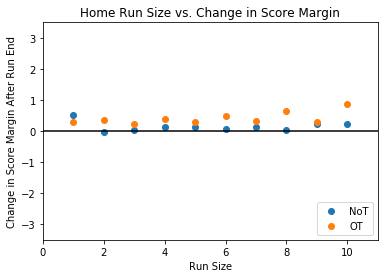

In [12]:
plot_averages(['NoT', 'OT'], np_combined)

### Home/Runner Timeout

This observation is further supported by examing sequences where the running (i.e., home) team called a timeout. There is a further increase in the score margin! Clearly, timeouts are not intrinsically beneficial to teams that are on the losing side of a run.

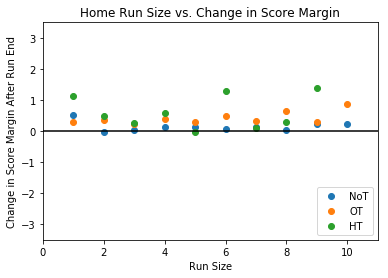

In [13]:
plot_averages(['NoT', 'OT','HT'], np_combined)
#plot_averages(seq_values.keys())

### Away/Slipper Timeout

You might naturally be inclined to ask, "What about the slipping/away teams!?" Timeouts do indeed help teams that are slipping score an additional ~1.5 points. It may be tempting to say "See! They <i>should</i> call timeouts!"

But one needs to examine the functional dependence of this relationship - that is, the expected score after a timeout has nearly zero dependence on run size: it's a flat line. This flat dependence extends continuously across the divide between running/slipping. <i><b>Any</b></i> team benefits from a timeout by approximately the same amount at any point in the game. There is no extra benefit of calling a timeout when you are losing. If anything, the benefit is increased when you call a timeout as the <i>runner</i> (an additional ~2.25 points compared to ~1.5 points for the slipping team). It's likely that this point advantage arises from the ability to run a set play, which one would expect to have a higher success rate. This effect should also be present in official timeouts, but as mentioned earlier, the unbiased nature of official timeouts results in a near-zero average change in margin.

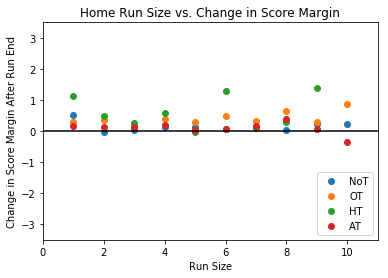

In [14]:
plot_averages(['NoT', 'OT', 'HT', 'AT'], np_combined)

### Runs by the Away Team

The axes are reversed so the trends are spatially the same as above. Note that the running team is now indicated by negative points. All other features are the same. 

The "away" run sequences have nearly the same features with the exception of an apparent home court advantage. Instead of centering around an expected score margin of ~0 points, the home team has a natural tendency to come back (i.e., no timeout and official timeout expected values of ~1 point). An interesting observation is that, when they are the running team, the away team seems to benefit even more when compared to the baseline (expected 1 point home advantage).

The score away timeout sequences with |value| > 7 should be somewhat doubted as there are very few examples of them (note the point at -8). However, the sequences with lower value have at least an order of magnitude more points, making them more reliable.

The regression toward zero of the one point runs is interesting as well. I'd suggest that perhaps crowd noise during free throws has something to do with this decrease in expected value 

All other features are the same, most importantly the absence of any kind of dependence of margin score on run size. 

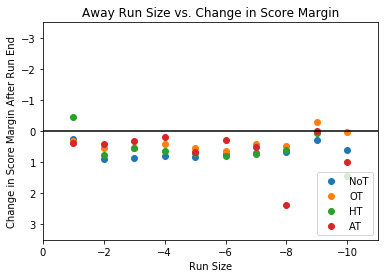

In [15]:
plot_averages(['NoT', 'OT', 'HT', 'AT'], np_combined, team='Away')

In [16]:
print('Number -8 away timeout runs:\n', np_combined[(5,'AT')].mean(), len(np_combined[(-8, 'AT')]))

Number -8 away timeout runs:
 0.0485074626866 11


## Conclusions

Timeouts are effective at winning a few marginal points. However, this effect has almost no relation with the size of a run and should not be considered necessary strategy for ending runs. When the slipping team does not have possession, timeouts appear to hurt the slipping team more than help them, as indicated by the larger score benefit to running teams when they call timeouts as well as the slight benefit of official timeouts to running teams. 

Thus, Roy Williams should feel vindicated in his refusal to call these timeouts that apparently have the exact opposite effect that fans and coaches seems to think. Not that he needs it with <a href="http://scout.com/college/north-carolina/Bolt/LOOK-UNCs-2017-National-Championship-Rings-107146391">his rings.</a>

## Supplemental Information

I was curious whethere there were any effects of parity on these results (that is, counting the next few scores as an even number or an odd number). To address this concern, I also calculate the same results using the next 3 scores instead of the next 4 scores. There were no noticeable differences.

Similarly, I calculated 5 and 6 scores. The only noticeable effect was a systematic decrease in the size of effects. That is, there is a general regression to zero average score margin as the post sequence length increases. This can be examined by altering the "scores" parameter in the "find_sequence_value" function.

The three score results are shown with their 4 score counterparts and indicated with "-1". These values are automatically calculated, so changing "scores" in find_sequence_value will automtically generate the "less one" sequences.

In [17]:
plot_averages(seq_values.keys())
plot_averages(seq_values.keys(), team='Away')

TypeError: plot_averages() missing 1 required positional argument: 'score_dictionary'

In [ ]:
#data.loc[(data.game_id == 253120183)]

In [ ]:
# Nice little alert to let me know when the Notebook has finished
from IPython.display import HTML
HTML('''<script>
alert('Done!')
</script>''')